In [ ]:
!pip install soundata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 15.3 MB/s eta 0:00:00


In [ ]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data


5.61GB [04:27, 22.5MB/s]                            
1.15MB [00:03, 394kB/s]                            
100%|██████████| 8732/8732 [00:40<00:00, 214.96it/s]

Clip(
  audio_path="/root/sound_datasets/urbansound8k/audio/fold4/154758-5-0-4.wav",
  clip_id="154758-5-0-4",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time: T

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Parámetros globales que usaremos luego
SR = 22050       # sample rate fijo
DURATION = 4.0   # duración objetivo en segundos
N_MFCC = 40      # número de coeficientes MFCC

print("TensorFlow:", tf.__version__)
print("Total de clips en el dataset:", len(dataset.clip_ids))

# Revisar el ejemplo que ya cargaste
y, sr = example_clip.audio
print("Shape del audio:", y.shape)
print("Sample rate original:", sr)
print("Clase (label):", example_clip.class_label)
print("Fold:", example_clip.fold)


TensorFlow: 2.19.0
Total de clips en el dataset: 8732
Shape del audio: (176400,)
Sample rate original: 44100
Clase (label): engine_idling
Fold: 4


In [ ]:
print(y), print(sr)

[-0.00196324 -0.00353852 -0.00465625 ... -0.01850595 -0.0169524
 -0.01051355]
44100


(None, None)

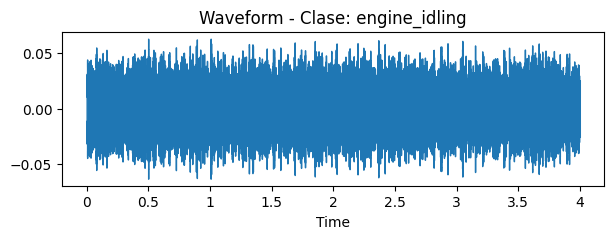

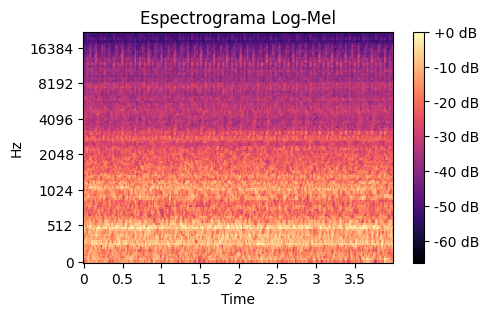

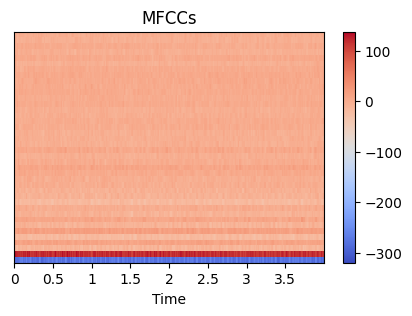

In [ ]:
# Visualizar la forma de onda
plt.figure(figsize=(7, 2))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - Clase: {example_clip.class_label}")
plt.show()

# Visualizar el espectrograma log-mel
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(5, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma Log-Mel")
plt.show()

# Visualizar los MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

plt.figure(figsize=(5, 3))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.show()


In [ ]:
def load_and_fix_audio(file_path, sr=SR, duration=DURATION):
    """
    Carga el audio, lo convierte en mono, lo re-muestrea y asegura duración fija
    """
    # carga audio con librosa
    y, original_sr = librosa.load(file_path, sr=sr, mono=True)

    # duración objetivo en samples
    target_len = int(sr * duration)

    # si es más largo -> recortar
    if len(y) > target_len:
        y = y[:target_len]

    # si es más corto -> padding con ceros
    if len(y) < target_len:
        pad_width = target_len - len(y)
        y = np.pad(y, (0, pad_width), mode='constant')

    return y


In [ ]:
def extract_mfcc_features(y, sr=SR, n_mfcc=N_MFCC):
    """
    Extrae MFCCs y devuelve un arreglo de tamaño (n_mfcc, T)
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc


In [ ]:
def process_clip(clip):
    """
    Recibe un clip de soundata y devuelve:
    - MFCCs del audio ya normalizado
    - label (class_id)
    """
    file_path = clip.audio_path
    y = load_and_fix_audio(file_path)
    mfcc = extract_mfcc_features(y)
    label = clip.class_id
    return mfcc, label


In [ ]:
def load_dataset_by_folds(dataset, folds):
    X = []
    Y = []
    for clip_id in dataset.clip_ids:
        clip = dataset.clip(clip_id)
        if clip.fold in folds:
            mfcc, label = process_clip(clip)
            X.append(mfcc)
            Y.append(label)
    return np.array(X), np.array(Y)



In [ ]:
def load_data_for_fold(dataset, test_fold):
    train_folds = [f for f in range(1, 11) if f != test_fold]

    X_train, y_train = load_dataset_by_folds(dataset, train_folds)
    X_test,  y_test  = load_dataset_by_folds(dataset, [test_fold])

    print(f"Fold {test_fold}: train={train_folds}, test={test_fold}")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

    return X_train, y_train, X_test, y_test


In [ ]:
def prepare_mlp_features(X):
    """
    Recibe X con forma (num_samples, n_mfcc, T)
    Devuelve X_mlp con forma (num_samples, n_mfcc)
    """
    X_out = []
    for mfcc in X:
        # promedio sobre tiempo → vector de 40
        vec = np.mean(mfcc, axis=1)
        X_out.append(vec)
    return np.array(X_out)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_mlp_model(input_dim, num_classes=10):
    """
    Construye un modelo MLP simple para clasificación de MFCC promediados.
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_accuracies = []   # aquí guardamos los accuracies de cada fold

for test_fold in range(1, 11):   # folds 1 → 10
    print("===================================================")
    print(f"🚀 Ejecutando Fold {test_fold} ...")
    print("===================================================")

    # 1. Cargar MFCC crudos (40, T)
    X_train_raw, y_train, X_test_raw, y_test = load_data_for_fold(dataset, test_fold=test_fold)

    print("Shapes iniciales:")
    print("X_train_raw:", X_train_raw.shape)
    print("X_test_raw:",  X_test_raw.shape)

    # 2. Convertir MFCC (40, T) → vectores (40,)
    X_train_mlp = prepare_mlp_features(X_train_raw)
    X_test_mlp  = prepare_mlp_features(X_test_raw)

    print("Shapes después de promedio temporal:")
    print("X_train_mlp:", X_train_mlp.shape)
    print("X_test_mlp:",  X_test_mlp.shape)

    # 3. Normalizar
    scaler = StandardScaler()
    X_train_mlp = scaler.fit_transform(X_train_mlp)
    X_test_mlp  = scaler.transform(X_test_mlp)

    # 4. Crear modelo MLP
    input_dim = X_train_mlp.shape[1]
    mlp_model = build_mlp_model(input_dim=input_dim)

    # 5. Entrenar
    history = mlp_model.fit(
        X_train_mlp, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_test_mlp, y_test),
        verbose=1
    )

    # 6. Evaluar
    test_loss, test_acc = mlp_model.evaluate(X_test_mlp, y_test, verbose=0)
    print(f"\n🎯 Accuracy del Fold {test_fold}: {test_acc:.4f}\n")

    fold_accuracies.append(test_acc)


# ===============================
# RESULTADOS FINALES DEL CV
# ===============================

acc_mean = np.mean(fold_accuracies)
acc_std  = np.std(fold_accuracies)

print("===================================================")
print("🔵 RESULTADOS DEL 10-FOLD CROSS VALIDATION (MLP)")
print("===================================================")
print("Accuracies por fold:", fold_accuracies)
print(f"\n📌 Accuracy promedio:      {acc_mean:.4f}")
print(f"📌 Desviación estándar:    {acc_std:.4f}")
print("===================================================")


🚀 Ejecutando Fold 1 ...
Fold 1: train=[2, 3, 4, 5, 6, 7, 8, 9, 10], test=1
Train size: 7859, Test size: 873
Shapes iniciales:
X_train_raw: (7859, 40, 173)
X_test_raw: (873, 40, 173)
Shapes después de promedio temporal:
X_train_mlp: (7859, 40)
X_test_mlp: (873, 40)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3562 - loss: 1.8164 - val_accuracy: 0.4765 - val_loss: 1.8394
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6334 - loss: 1.0819 - val_accuracy: 0.4754 - val_loss: 1.9491
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6962 - loss: 0.8893 - val_accuracy: 0.5292 - val_loss: 2.0020
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7355 - loss: 0.7676 - val_accuracy: 0.4960 - val_loss: 2.1587
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7766 - loss: 0.6638 - val_accuracy: 0.5006 - val_loss: 2.4225
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8000 - loss: 0.5985 - val_accuracy: 0.5074 - val_loss: 2.5351
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8133 - loss: 0.5568 - val_accuracy: 0.5258 - val_loss: 2.6084
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8209 - loss: 0.5268 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3510 - loss: 1.8072 - val_accuracy: 0.4347 - val_loss: 1.5875
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6330 - loss: 1.0992 - val_accuracy: 0.4493 - val_loss: 1.6946
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6964 - loss: 0.9031 - val_accuracy: 0.4595 - val_loss: 1.7144
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7456 - loss: 0.7638 - val_accuracy: 0.5124 - val_loss: 1.9220
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7589 - loss: 0.7343 - val_accuracy: 0.5191 - val_loss: 1.9616
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7818 - loss: 0.6441 - val_accuracy: 0.5056 - val_loss: 2.2241
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8003 - loss: 0.5882 - val_accuracy: 0.5214 - val_loss: 2.0636
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8200 - loss: 0.5270 - val_accuracy: 0.4977 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3634 - loss: 1.8186 - val_accuracy: 0.4292 - val_loss: 1.6394
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6357 - loss: 1.0578 - val_accuracy: 0.4627 - val_loss: 1.8314
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6971 - loss: 0.8952 - val_accuracy: 0.4497 - val_loss: 1.7998
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7469 - loss: 0.7781 - val_accuracy: 0.4616 - val_loss: 2.0995
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7742 - loss: 0.6689 - val_accuracy: 0.4746 - val_loss: 2.1805
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7962 - loss: 0.5988 - val_accuracy: 0.4670 - val_loss: 2.1638
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8088 - loss: 0.5631 - val_accuracy: 0.4714 - val_loss: 2.1263
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8301 - loss: 0.4994 - val_accuracy: 0.4670 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3496 - loss: 1.8341 - val_accuracy: 0.4778 - val_loss: 1.4311
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6221 - loss: 1.1017 - val_accuracy: 0.5111 - val_loss: 1.4428
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7007 - loss: 0.8815 - val_accuracy: 0.5091 - val_loss: 1.4905
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7287 - loss: 0.7886 - val_accuracy: 0.5323 - val_loss: 1.4950
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7781 - loss: 0.6727 - val_accuracy: 0.5071 - val_loss: 1.6220
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7913 - loss: 0.6168 - val_accuracy: 0.5101 - val_loss: 1.7505
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7996 - loss: 0.5637 - val_accuracy: 0.5242 - val_loss: 1.7695
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8296 - loss: 0.5041 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3497 - loss: 1.8593 - val_accuracy: 0.5620 - val_loss: 1.2784
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6212 - loss: 1.1249 - val_accuracy: 0.6015 - val_loss: 1.2532
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6987 - loss: 0.8916 - val_accuracy: 0.5887 - val_loss: 1.2856
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7404 - loss: 0.7716 - val_accuracy: 0.5620 - val_loss: 1.2762
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7725 - loss: 0.6951 - val_accuracy: 0.6026 - val_loss: 1.2284
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7979 - loss: 0.6110 - val_accuracy: 0.5951 - val_loss: 1.2619
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8166 - loss: 0.5593 - val_accuracy: 0.5972 - val_loss: 1.2912
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8242 - loss: 0.5262 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3650 - loss: 1.8218 - val_accuracy: 0.4277 - val_loss: 1.6347
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6438 - loss: 1.0765 - val_accuracy: 0.4763 - val_loss: 1.5945
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7053 - loss: 0.8684 - val_accuracy: 0.4544 - val_loss: 1.7173
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7496 - loss: 0.7467 - val_accuracy: 0.4642 - val_loss: 1.7291
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7692 - loss: 0.6769 - val_accuracy: 0.4897 - val_loss: 1.8785
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - loss: 0.6030 - val_accuracy: 0.4727 - val_loss: 1.8316
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8038 - loss: 0.5745 - val_accuracy: 0.4775 - val_loss: 1.9520
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8245 - loss: 0.5016 - val_accuracy: 0.5006 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3521 - loss: 1.8291 - val_accuracy: 0.5752 - val_loss: 1.2909
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6239 - loss: 1.0836 - val_accuracy: 0.5835 - val_loss: 1.1788
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6953 - loss: 0.8927 - val_accuracy: 0.5967 - val_loss: 1.1483
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7309 - loss: 0.7975 - val_accuracy: 0.6158 - val_loss: 1.1518
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7642 - loss: 0.6989 - val_accuracy: 0.6014 - val_loss: 1.1777
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7839 - loss: 0.6492 - val_accuracy: 0.5955 - val_loss: 1.1367
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8055 - loss: 0.5837 - val_accuracy: 0.6110 - val_loss: 1.1728
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8225 - loss: 0.5311 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3500 - loss: 1.8442 - val_accuracy: 0.5596 - val_loss: 1.2889
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6251 - loss: 1.0951 - val_accuracy: 0.5372 - val_loss: 1.4298
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7024 - loss: 0.8812 - val_accuracy: 0.5695 - val_loss: 1.4154
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7488 - loss: 0.7560 - val_accuracy: 0.6005 - val_loss: 1.4169
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7748 - loss: 0.6723 - val_accuracy: 0.5794 - val_loss: 1.5157
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8027 - loss: 0.5964 - val_accuracy: 0.5658 - val_loss: 1.5830
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8149 - loss: 0.5447 - val_accuracy: 0.5943 - val_loss: 1.6255
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8270 - loss: 0.5121 - val_accuracy: 0.5844 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3641 - loss: 1.8214 - val_accuracy: 0.5221 - val_loss: 1.4130
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6297 - loss: 1.0873 - val_accuracy: 0.5723 - val_loss: 1.4758
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6966 - loss: 0.8720 - val_accuracy: 0.5931 - val_loss: 1.5352
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7445 - loss: 0.7654 - val_accuracy: 0.6078 - val_loss: 1.6222
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7693 - loss: 0.6789 - val_accuracy: 0.5882 - val_loss: 1.6334
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7963 - loss: 0.6099 - val_accuracy: 0.5870 - val_loss: 1.7056
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8105 - loss: 0.5583 - val_accuracy: 0.6201 - val_loss: 1.7556
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8320 - loss: 0.5070 - val_accuracy: 0.5919 - val

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3372 - loss: 1.8661 - val_accuracy: 0.5233 - val_loss: 1.4236
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6393 - loss: 1.0711 - val_accuracy: 0.5078 - val_loss: 1.4317
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 0.8800 - val_accuracy: 0.5293 - val_loss: 1.4363
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7466 - loss: 0.7685 - val_accuracy: 0.5317 - val_loss: 1.4584
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7625 - loss: 0.6834 - val_accuracy: 0.5376 - val_loss: 1.4778
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7943 - loss: 0.6181 - val_accuracy: 0.5460 - val_loss: 1.5089
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8059 - loss: 0.5721 - val_accuracy: 0.5436 - val_loss: 1.5215
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8274 - loss: 0.5283 - val_accuracy: 0.5424 - val